In [1]:
import csv
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict, Counter
import numpy as np
import math
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from tqdm import tqdm
import string

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [6]:
# id,title,url,score,time,comments,author
data = pd.read_csv('data.csv')
data = data.dropna(subset=['title', 'time', 'score'])

print(f'Number of posts: {len(data)}')

# remove all post that contains "HN" in the title and ealier than 2020
data = data[~data['title'].str.contains('HN')]
data = data[data['time'] >= 1609459200]
print(f'Number of filtered posts: {len(data)}')

Number of posts: 4010950
Number of filtered posts: 662753


In [7]:
print('Average score of all posts:', data['score'].mean(), data['score'].median())

Average score of all posts: 21.403381048444896 2.0


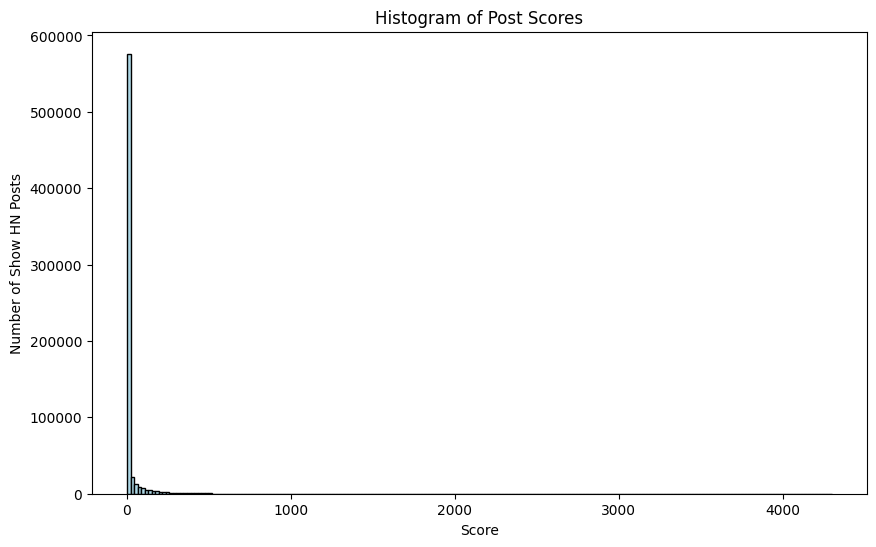

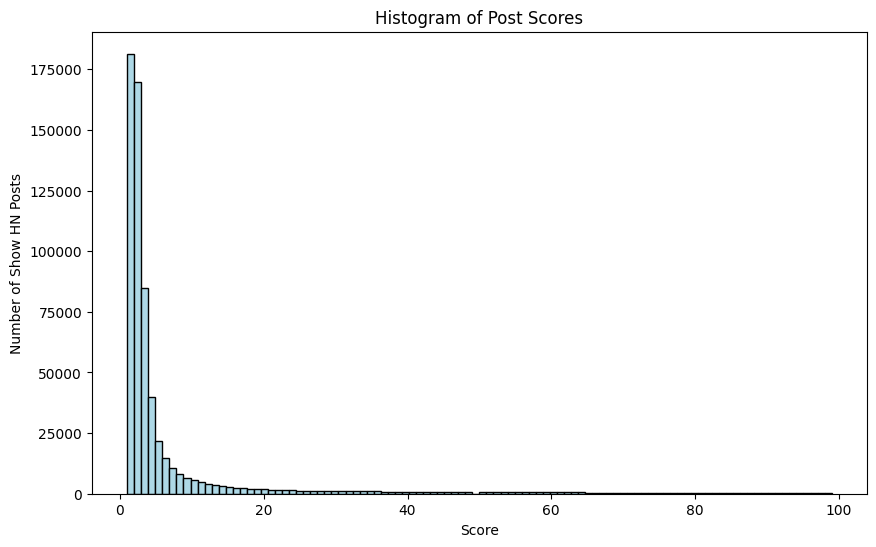

In [9]:
scores = data['score'].tolist()

plt.figure(figsize=(10, 6))
plt.hist(scores, bins=200, color='lightblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Number of Show HN Posts')
plt.title('Histogram of Post Scores')
plt.show()

scores = data['score'].tolist()
scores = [score for score in scores if score < 100]

plt.figure(figsize=(10, 6))
plt.hist(scores, bins=100, color='lightblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Number of Show HN Posts')
plt.title('Histogram of Post Scores')
plt.show()

In [11]:
posts_by_weekday = Counter()
posts_by_hour = Counter()
scores_by_weekday = defaultdict(list)
scores_by_hour = defaultdict(list)
scores_by_hour_of_week = defaultdict(list)
for _, item in data.iterrows():
    timestamp = datetime.fromtimestamp(item['time'], tz=pytz.utc).astimezone(pytz.timezone('America/Los_Angeles'))
    weekday = timestamp.strftime('%A')  # Get the full weekday name
    hour = timestamp.strftime('%H')  # Get the hour
    weekday_hour = timestamp.strftime('%A %H')  # Combine day of the week with hour
    posts_by_weekday[weekday] += 1
    posts_by_hour[hour] += 1
    scores_by_weekday[weekday].append(int(item['score']))
    scores_by_hour[hour].append(int(item['score']))
    scores_by_hour_of_week[weekday_hour].append(int(item['score']))

# Sort counts by the order in the week starting from Monday
sorted_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorted_hours = sorted(posts_by_hour.keys())

posts_sorted_by_weekday = {day: posts_by_weekday[day] for day in sorted_days if day in posts_by_weekday}

posts_sorted_by_hour = {hour: posts_by_hour[hour] for hour in sorted_hours if hour in posts_by_hour}

avg_scores_by_weekday = {day: sum(scores)/len(scores) for day, scores in scores_by_weekday.items()}
avg_scores_sorted_by_weekday = {day: avg_scores[day] for day in sorted_days if day in avg_scores_by_weekday}

avg_scores_by_hour = {hour: sum(scores)/len(scores) for hour, scores in scores_by_hour.items()}
avg_scores_sorted_by_hour = {hour: avg_scores_by_hour[hour] for hour in sorted_hours}

avg_scores_by_hour_of_week = {key: sum(values)/len(values) for key, values in scores_by_hour_of_week.items()}
sorted_avg_scores_by_hour_of_week = OrderedDict(sorted(avg_scores_by_hour_of_week.items(), key=lambda x: (sorted_days.index(x[0].split()[0]), int(x[0].split()[1]))))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(posts_sorted_by_weekday.keys(), posts_sorted_by_weekday.values(), color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Posts')
plt.title('Number of Posts by Day of the Week (California Time)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(posts_sorted_by_hour.keys(), posts_sorted_by_hour.values(), color='lightgreen')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Posts')
plt.title('Number of Posts by Day of the Week (California Time)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(avg_scores_sorted_by_weekday.keys(), avg_scores_sorted_by_weekday.values(), color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Score')
plt.title('Average Score of Posts by Day of the Week (California Time)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(avg_scores_sorted_by_hour.keys(), avg_scores_sorted_by_hour.values(), color='lightgreen')
plt.xlabel('Hour of the Day (California Time)')
plt.ylabel('Average Score')
plt.title('Average Score of Posts by Hour of the Day (California Time)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 8))
plt.bar(range(len(sorted_avg_scores_by_hour_of_week )), list(sorted_avg_scores_by_hour_of_week .values()), align='center', color='orchid')
plt.xlabel('Day and Hour of the Week (California Time)')
plt.ylabel('Average Score')
plt.title('Average Score of Posts by Hour of the Week (California Time)')
plt.xticks(range(len(sorted_avg_scores_by_hour_of_week )), list(sorted_avg_scores_by_hour_of_week .keys()), rotation=90)
plt.tight_layout()
plt.show()

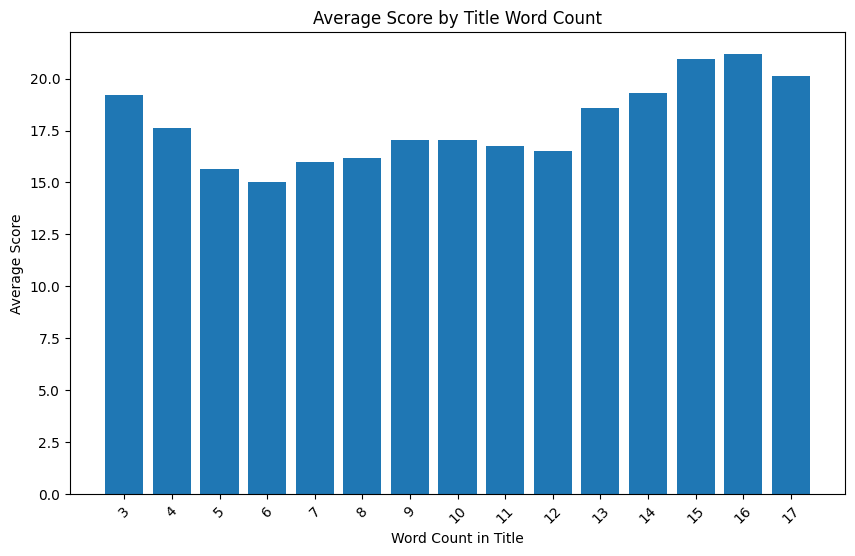

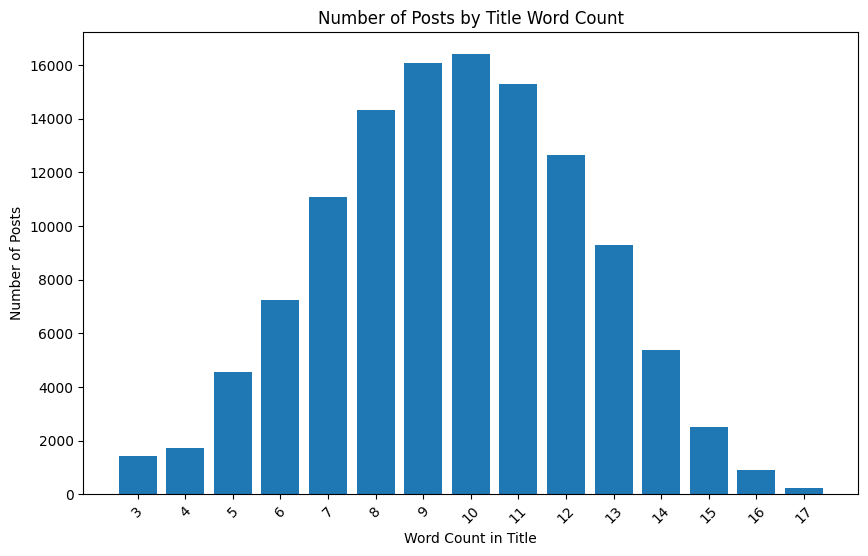

In [171]:
word_counts = defaultdict(list)
sorted_word_counts = sorted(word_counts.keys())
posts_counts = {}
for _, row in data.iterrows():
    word_count = len(row['title'].split())
    word_counts[word_count].append(int(row['score']))

    if word_count in posts_counts:
        posts_counts[word_count] += 1
    else:
        posts_counts[word_count] = 1

# filter out buckets with too few samples
word_counts = {wc: scores for wc, scores in word_counts.items() if len(scores) >= 100}

# Step 2: Calculate average scores for each word count
average_scores = {wc: sum(scores)/len(scores) for wc, scores in word_counts.items()}

# Prepare data for plotting
sorted_word_counts = sorted(average_scores.keys())
average_scores_list = [average_scores[wc] for wc in sorted_word_counts]

plt.figure(figsize=(10, 6))
plt.bar(range(len(average_scores)), average_scores_list, tick_label=sorted_word_counts)
plt.title('Average Score by Title Word Count')
plt.xlabel('Word Count in Title')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_word_counts)), [posts_counts[wc] for wc in sorted_word_counts], tick_label=sorted_word_counts)
plt.title('Number of Posts by Title Word Count')
plt.xlabel('Word Count in Title')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

In [172]:
scores_upper = []
scores_lower = []
for _, row in show_hn_data.iterrows():
    words = row['title'].split()
    upper_count = sum([w[0].upper() == w[0] for w in words])
    ratio = upper_count / len(words)
    if ratio > 0.7:
        scores_upper.append(row['score'])
    if ratio < 0.5:
        scores_lower.append(row['score'])

print('Average score', show_hn_data['score'].mean())
print('Average score of posts with upper cases', sum(scores_upper) / len(scores_upper))
print('Average score of posts with lower cases', sum(scores_lower) / len(scores_lower))

Average score 16.95587075777148
Average score of posts with upper cases 14.643670680117149
Average score of posts with lower cases 17.482964866421515


In [191]:
scores = []
for _, row in show_hn_data.iterrows():
    words = row['title'].split()
    if 'I' in words:
        scores.append(row['score'])

print('Average score of Show HN with "I" in title:', sum(scores) / len(scores))

Average score of Show HN with "I" in title: 34.35147190008921


In [207]:
# Initialize stemmer
stemmer = PorterStemmer()
# stop_words = set(stopwords.words('english'))
stop_words = set()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # stemming
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens
    

stem_to_scores = {}

for _, d in tqdm(show_hn_data.iterrows()):
    tokens = preprocess_text(d['title'])
    for token in tokens:
        if token not in stem_to_scores:
            stem_to_scores[token] = []
        stem_to_scores[token].append(int(d['score']))

stem_to_scores = {stem: scores for stem, scores in stem_to_scores.items() if len(scores) >= 300}

stem_to_avg_score = {stem: sum(scores) / len(scores) for stem, scores in stem_to_scores.items()}

print('Top 100 stems by average score(stem, avg_score, num_occurence):')
for stem, avg_score in sorted(stem_to_avg_score.items(), key=lambda x: x[1], reverse=True)[:100]:
    print(stem, avg_score, len(stem_to_scores[stem]))

print('Bottom 100 stems by average score (stem, avg_score, num_occurence):')
for stem, avg_score in sorted(stem_to_avg_score.items(), key=lambda x: x[1])[:100]:
    print(stem, avg_score, len(stem_to_scores[stem]))

119218it [00:19, 6225.53it/s]

Top 100 stems by average score(stem, avg_score, num_occurence):
im 48.45723684210526 304
wrote 45.00923076923077 325
altern 43.29887410440123 977
year 41.26732673267327 404
opensourc 40.01171605789111 1451
linux 37.5967365967366 429
simul 35.66522678185745 463
i 34.36167485580004 4681
brows 31.606811145510836 323
book 30.422890397672163 1031
sql 30.05841121495327 428
modern 29.99357601713062 467
pdf 29.516806722689076 476
made 28.853241077931536 2746
faster 28.837628865979383 388
css 28.764238410596025 755
html5 28.348837209302324 430
program 28.30256898192198 1051
termin 27.821739130434782 690
editor 27.70179640718563 835
hacker 27.60766283524904 1305
databas 27.451487710219922 773
languag 26.92922794117647 1088
’ 26.92128279883382 343
algorithm 26.5 382
thi 26.41343669250646 774
3d 26.148529411764706 680
comput 26.10955710955711 429
where 25.986263736263737 364
built 25.984189723320156 2530
markdown 25.577319587628867 582
puzzl 25.47147147147147 333
color 25.29136690647482 556
ui 25.

In [211]:
# test_input = 'I analyzed 4 millions HN posts and used the tricks I found to get to the top Show HN of the day'
test_input = 'I open-sourced the in-memory PostgreSQL I built at work for E2E tests'
stems = preprocess_text(test_input)

for stem in stems:
    score = stem_to_avg_score.get(stem)
    if score and (score < 12 or score > 20):
        print(stem, score, len(stem_to_scores.get(stem, [])))

i 34.36167485580004 4681
opensourc 40.01171605789111 1451
i 34.36167485580004 4681
built 25.984189723320156 2530
work 23.095281306715062 1102
test 11.103148024112524 1493
